## Imports

In [1]:
%%time
'''
import pandas  as pd
import seaborn as sns
import numpy   as np
import matplotlib.pyplot as plt
from scipy.signal    import find_peaks
from scipy.integrate import simps, trapz
from scipy.optimize  import curve_fit
'''

from mainFile import *

mainFile e bibliotecas importados
Wall time: 1.54 s


## Lendo arquivo das waveforms
#### O arquivo original já foi parcialmente modificado em relação a linhas e colunas

In [2]:
%%time
'''Lendo arquivo das waveforms'''

waveform = pd.read_csv('data/5555_eventos-edit.csv',     index_col = 0) # importa como waveform vs sample

Wall time: 3.44 s


## 3. ANÁLISE DE DADOS

## 3.1. Copia o data frame e seleciona a janela de busca

Cria uma cópia das waveforms para poder transladar o base line sem modificar os dados originais;

Define a janela onde procuraremos pelos valores do contorno do pulso

In [3]:
df = waveform.copy(deep = True)
df = df.iloc[ : , :df.shape[1] - 1 ]

VA_1 = 20 # VA_1 e VA_2 são variáveis arbitrárias para definir o majorante da largura dos pulsos
VA_2 = 70

convert_to_microsec = 1/250

## 3.2. Translação da base-line

É interessante transladar os pontos e fixar a base line no 0. Podemos fazer isso somando ~= -50 em cada um dos valores de toda a coleção de waveforms. Isso servirá para evitar problemas de 'height' no peak_finder()

Análise estatística do base-line:
No caso, tomaremos todos os dados antes do primeiro pulso de cada waveform e consideraremos o base-line como o mesmo para todos os waveforms

        Método:

Para encontrar a base line, selecionaremos a parte mais à esquerda, antes do pulso. Esse pedaço é definido como fora de um valor arbitrário em torno do primeiro pico da waveform, que acaba não sofrendo com a questão da base line. Definimos desse jeito porque a função para calcular o contorno do pulso, além de demorar para ser computada, sofre com as questões do peak_finder acabar encontrando apenas um elemento


In [4]:
%%time

height = 50 # esse parâmetro aqui é somente para efeito de encontrar os elementos da  base line a priori

baseLines = baseLine(df=df, height=height, VA_1=VA_1)

Wall time: 2.18 s


        Relocação do base-line:
Colocando o valor médio do base line como o parâmetro height do peak-finder, surpreendentemente temos um resultado que não incorre em erros na hora de achar os dois picos de cada waveform. No caso, ele acaba por achar dois picos (não mais nem menos) de maneira mais fácil e exata

In [5]:
'''
Alterando os valores e recolocando na base line ~= 0
'''

df.iloc[ :  , : df.shape[1] ] -= baseLines.mean() 
# soma ~= -50 em todo o df, exceto pela última coluna 'time'
df.head(2)

height = baseLines.mean()

In [6]:
# %%time
# '''
# Filtrando os dados de acordo com o valor do tempo de vida do muon
# '''
# df_filt_delta_t = filtra_delta_t(df=df, convert_to_microsec=convert_to_microsec, time_in_ADCch=5, height=height)

## Curve fit exponencial da diferença de tempo


           valor  incerteza
A    707.655718   2.339355
tau    2.143807   0.015925
C      3.960233   1.115376 



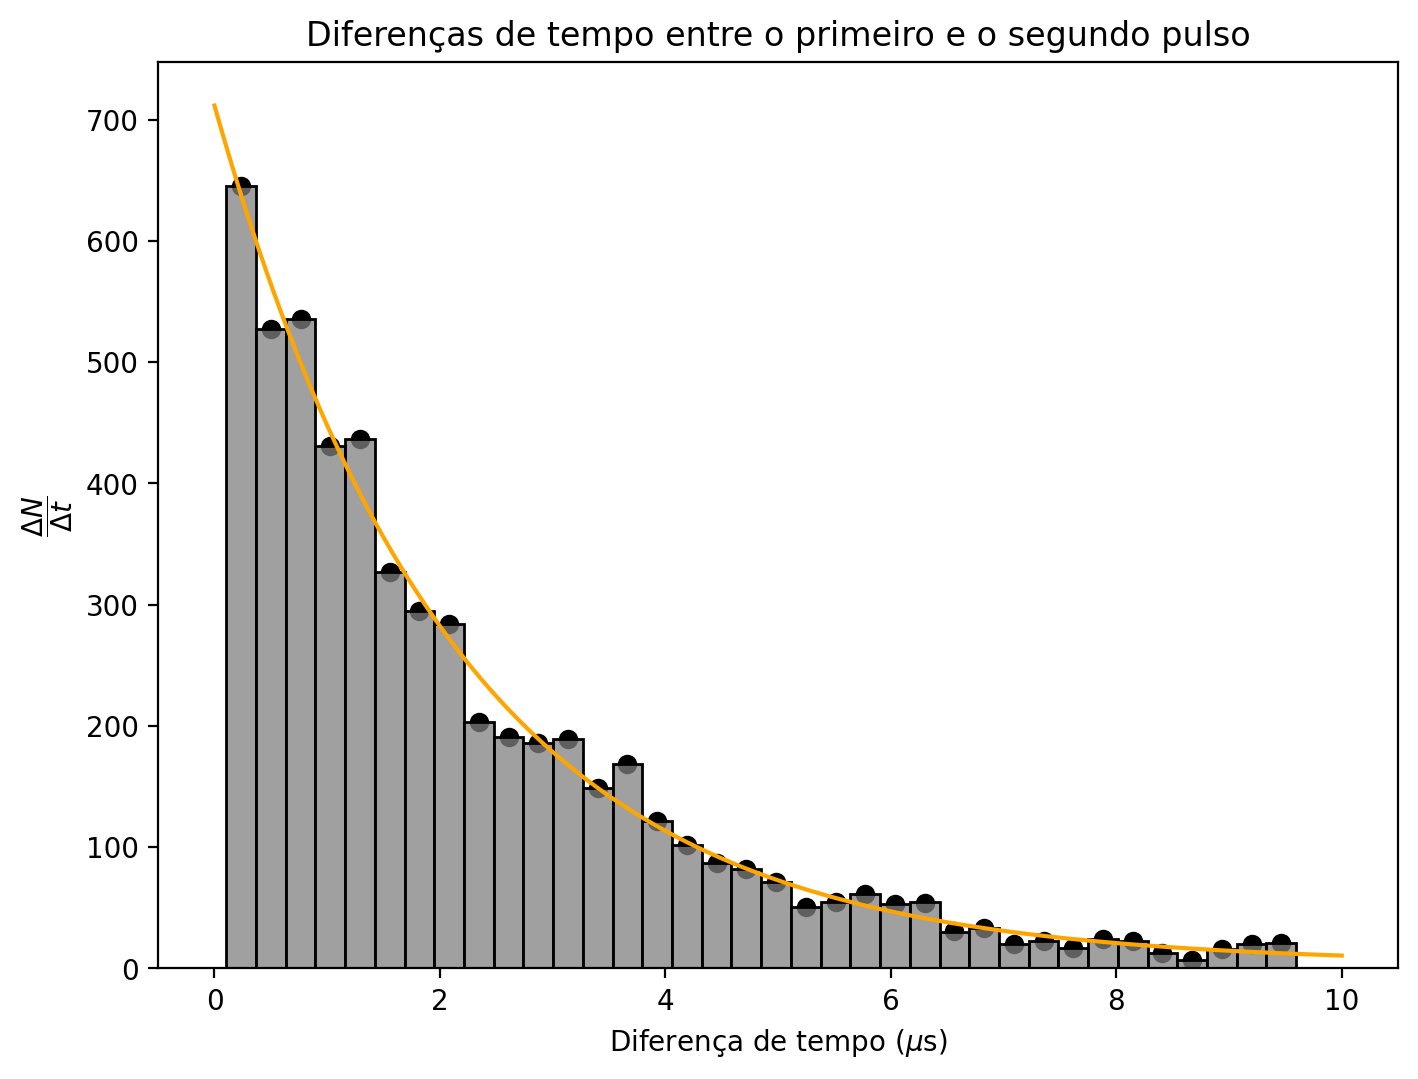

In [12]:
#%%time

table, fig = curve_fit_exponencial(df=df , height=height, convert_to_microsec=convert_to_microsec, plt_points=1, plt_bars=1)

fig.savefig('images/exp_fit_deltaT.png')
print('\n', table, '\n')

## 4.1. Loop para construção e check do peak_finder
Esse loop cria e checa se existem erros na obtenção dos picos através da função peak-finder, quando peaks != 2

In [13]:
%%time
peaks_xy_0   ,   peaks_xy_1    =    peaks_divididos_01(df=df, height = baseLines.mean())
peaks_xy_0.index = peaks_xy_0.index // 2
peaks_xy_1.index = peaks_xy_1.index // 2

Wall time: 3.46 s


# 5. Plot espectro de amplitude

## 5.1. Plot do espectro de amplitude do primeiro pulso 

In [14]:
# sns.histplot( -1*peaks_xy_0['y'].round() )
# plt.title('Espectro de amplitude do muon')
# plt.xlabel('Máximo do pulso')
# plt.savefig("images/espectro_amplitude-pulso_0.png", dpi = 150)

In [15]:
#sns_plot = sns.histplot( -1*peaks_xy_0.query('y > y.min()')['y'] )
#plt.title('Espectro de amplitude do muon [sem saturação]')
#plt.savefig("images/espectro_amplitude_0_ZOOM.png", dpi = 150)

## 5.3. Plot do espectro de amplitude do segundo pulso 

In [16]:
# sns.histplot( -1*peaks_xy_1['y'].round() )
# plt.title('Espectro de amplitude do eletron')
# plt.savefig("images/espectro_amplitude_1.png", dpi = 150)

In [17]:
#sns.histplot( -1*peaks_xy_1.query('y > y.min()')['y'] )
#plt.title('Espectro de amplitude do eletron [sem saturação]')
#plt.savefig("images/espectro_amplitude_1_ZOOM.png", dpi = 150)

# 6. Plot dos espectro de carga

## 6.2. Integração do pulso 

Integramos o pulso para obter a carga gerada com ele. Utilizamos a integração pelo método de Simpson.

In [18]:
%%time
_ = contorno_limite_arbitrario_picos(
    df=df, peaks_01=(peaks_xy_0,peaks_xy_1), VA_1=VA_1, VA_2=VA_2, height=height
                                    )


Foram detectados 21 problemas na questão do tamanho da janela do contorno;
Os problemas estão em [6, 7, 8, 9, 213, 608, 1821, 2277, 2509, 3310, 3612, 3613, 3614, 3615, 3616, 4301, 4397, 4398, 4399, 4572, 5427];
Preenchidos com valores Nan

Wall time: 8.03 s


In [19]:
#plt.plot(df.event_6.iloc[2200:2500])
#plt.title('exemplo de problema com os picos')

In [20]:
%%time
integrais_0 = integral_simples_dataframe(_[0], dx=1)
integrais_1 = integral_simples_dataframe(_[1], dx=1)

Wall time: 10.5 s


In [21]:
# sns.histplot(-1*integrais_0)
# plt.title("Espectro de carga - pulso do muon (0)")
# plt.xlabel('Carga (unidades)')
# plt.savefig("images/espectro_carga-pulso_0.png", dpi = 150)

In [22]:
# sns.histplot(-1*integrais_1)
# plt.title("Espectro de carga - pulso do eletron (1)")
# plt.xlabel('Carga (unidades)')
# plt.savefig("images/espectro_carga-pulso_1.png", dpi = 150)

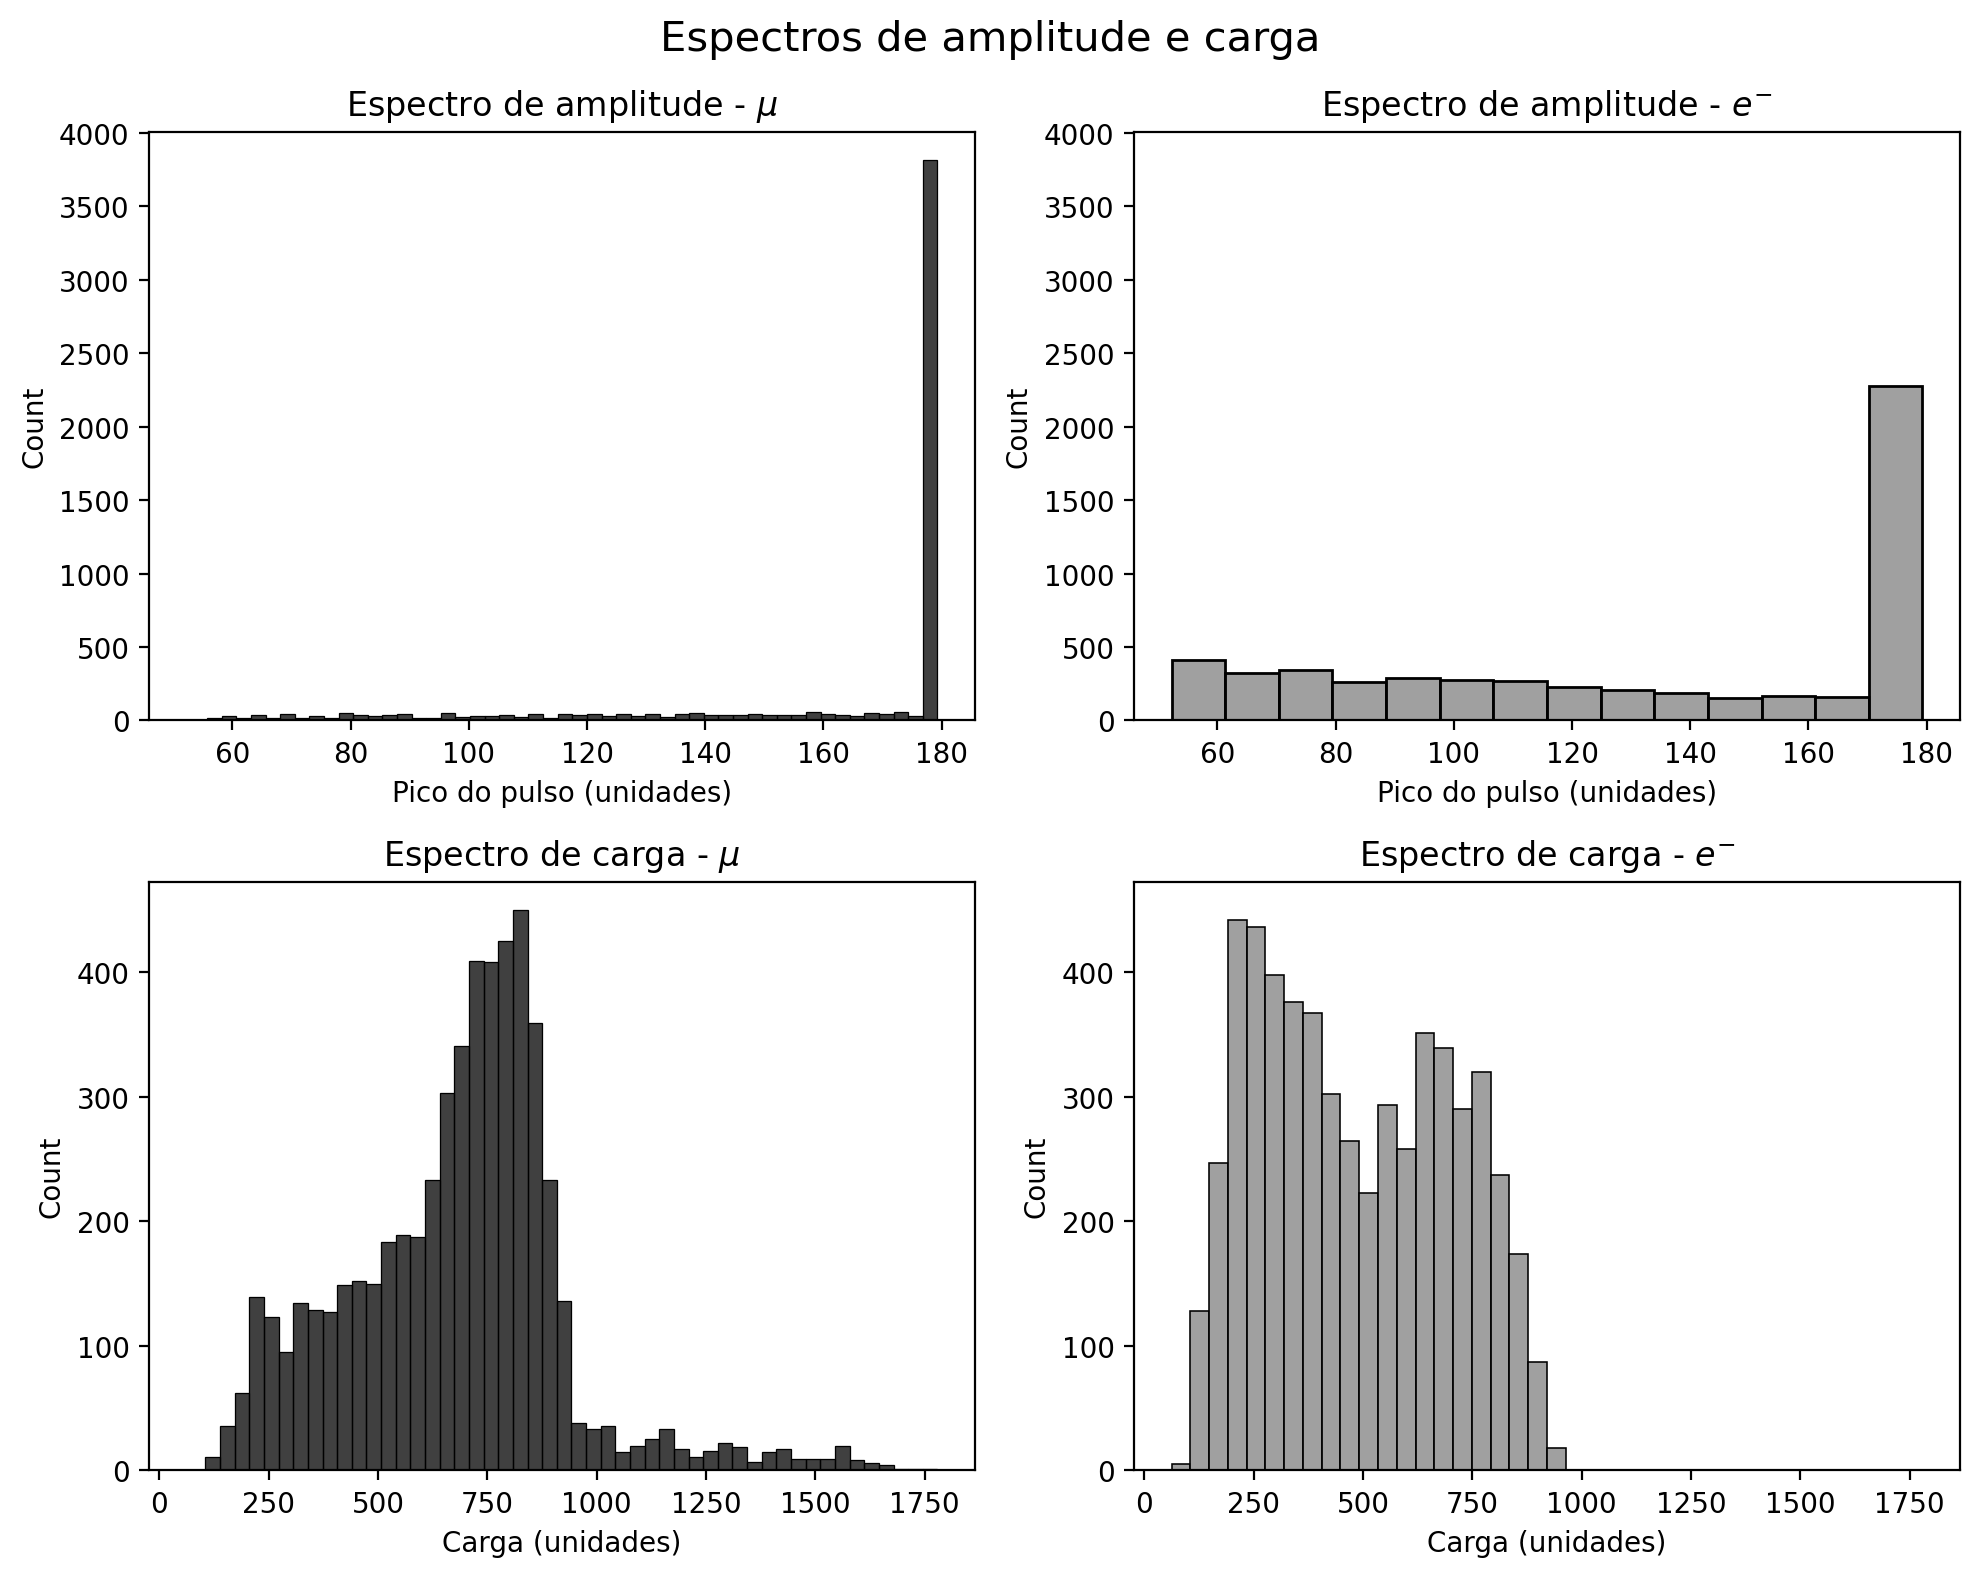

In [23]:
fig = plt.figure(dpi=200, figsize=(10,8))
fig.suptitle('Espectros de amplitude e carga', fontsize=15)

ax1 = plt.subplot(221)
sns.histplot( -1*peaks_xy_0['y'], color='black' )
plt.xlabel('Pico do pulso (unidades)')
plt.title(r"Espectro de amplitude - $\mu$")

ax2 = plt.subplot(222, sharex=ax1, sharey=ax1)
sns.histplot( -1*peaks_xy_1['y'] , color='gray')
plt.xlabel('Pico do pulso (unidades)')
plt.title(r"Espectro de amplitude - $e^{-}$")

ax3 = plt.subplot(223)
sns.histplot(-1*integrais_0, color='black')
plt.xlabel('Carga (unidades)')
plt.title(r"Espectro de carga - $\mu$")

ax4 = plt.subplot(224, sharex=ax3, sharey=ax3)
sns.histplot(-1*integrais_1, color='gray')
plt.xlabel('Carga (unidades)')
plt.title(r"Espectro de carga - $e^{-}$")

fig.tight_layout()

plt.savefig('images/espectros_orig.png')

## Filtrando as saturações

In [24]:
# plt.plot(df.event_4, color = 'green', label = 'event_4')
# plt.plot(df.event_6, color = 'black', label = 'event_6')
# plt.legend()
# plt.title('Saturações em apenas um pico')

In [25]:
#%%time
#df_filt_sat_tot = filtra_saturacao_total( df=df , height=height , VA_1=VA_1 , VA_2=VA_2 )

In [26]:
%%time
df_filt_parcial = filtra_saturacao_parcial(df=df, height=height, VA_1=VA_1, VA_2=VA_2)
peaks_xy_0_filt   ,   peaks_xy_1_filt    =    df_filt_parcial
peaks_xy_0_filt.index = peaks_xy_0_filt.index // 2
peaks_xy_1_filt.index = peaks_xy_1_filt.index // 2

Wall time: 3.29 s


In [27]:
%%time
_ = contorno_limite_arbitrario_picos(df=df, peaks_01=df_filt_parcial, VA_1=VA_1, VA_2=VA_2, height=height)


Foram detectados 13 problemas na questão do tamanho da janela do contorno;
Os problemas estão em [213, 608, 3310, 3612, 3613, 3614, 3615, 3616, 4301, 4397, 4398, 4399, 4572];
Preenchidos com valores Nan

Wall time: 3.79 s


In [28]:
%%time
integrais_0_filt = integral_simples_dataframe(_[0], dx=1)
integrais_1_filt = integral_simples_dataframe(_[1], dx=1)

Wall time: 4.92 s


In [29]:
# sns.histplot( -1*peaks_xy_0_filt['y'].round() )
# plt.title('Espectro de amplitude do muon Filtrado')
# plt.xlabel('Máximo do pulso')
# plt.savefig("images/espectro_amplitude-pulso_0_filtrado.png", dpi = 150)

In [30]:
# sns.histplot( -1*peaks_xy_1_filt['y'].round() )
# plt.title('Espectro de amplitude do eletron Filtrado')
# plt.savefig("images/espectro_amplitude_1_filtrado.png", dpi = 150)

In [31]:
# sns.histplot(-1*integrais_0_filt)
# plt.title("Espectro de carga - pulso do muon (0) Filtrado")
# plt.xlabel('Carga (unidades)')
# plt.savefig("images/espectro_carga-pulso_0_filtrado.png", dpi = 150)

In [32]:
# sns.histplot(-1*integrais_1_filt)
# plt.title("Espectro de carga - pulso do eletron (1) Filtrado")
# plt.xlabel('Carga (unidades)')
# plt.savefig("images/espectro_carga-pulso_1_filtrado.png", dpi = 150)

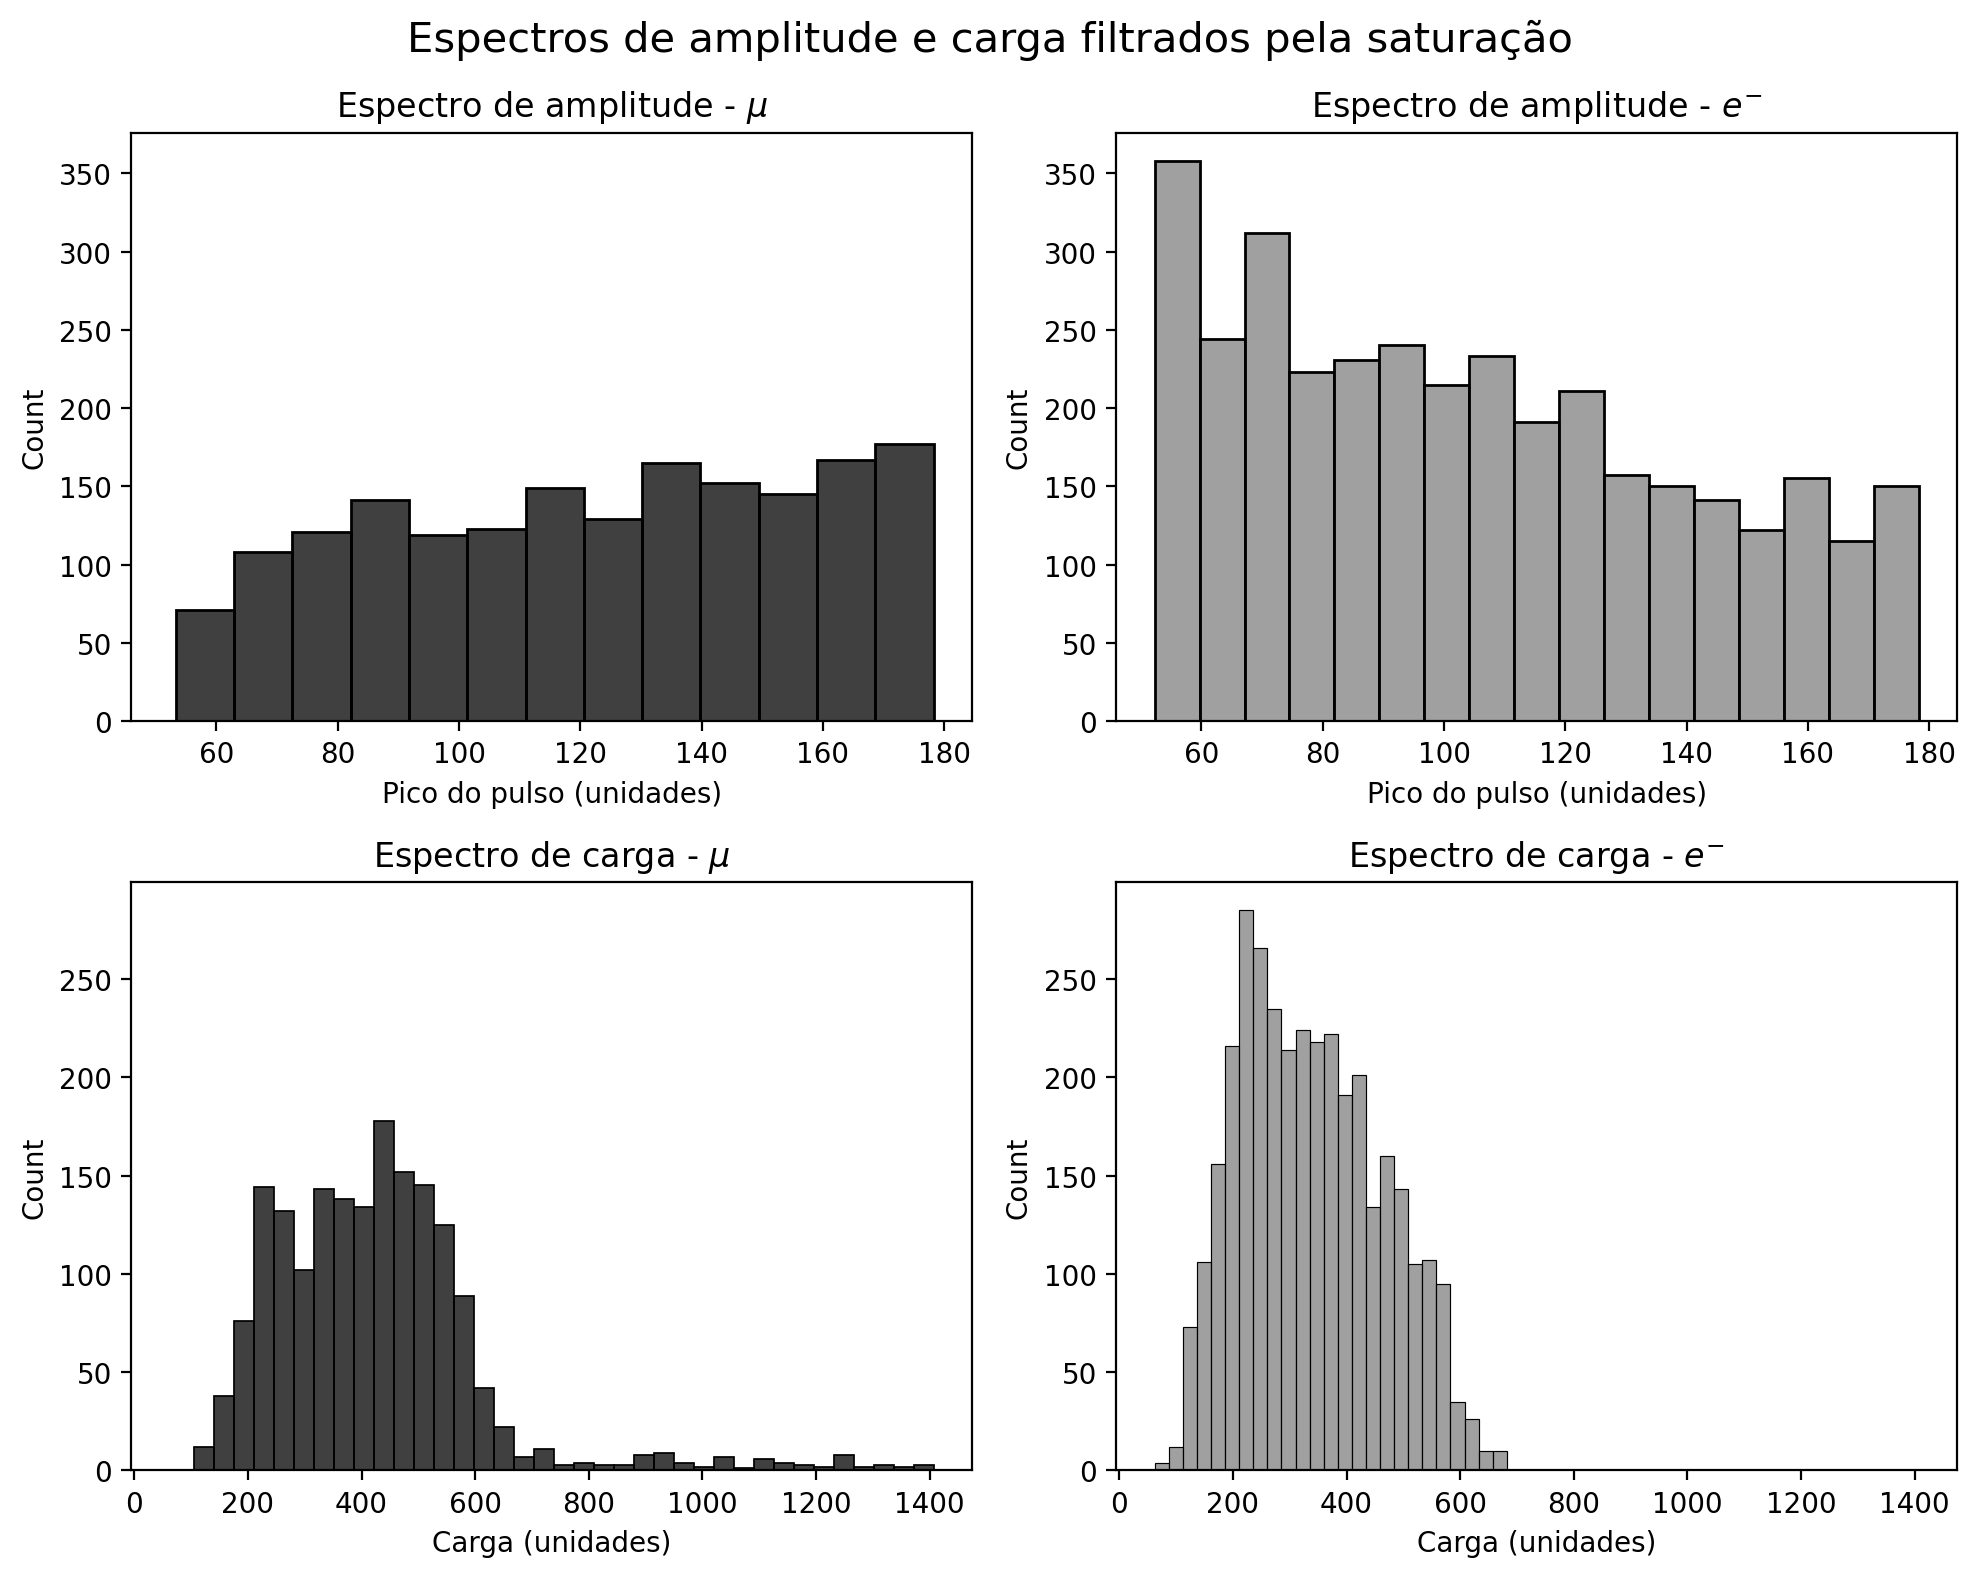

In [33]:
fig = plt.figure(dpi=200, figsize=(10,8))
fig.suptitle('Espectros de amplitude e carga filtrados pela saturação', fontsize=15)

ax1 = plt.subplot(221)
sns.histplot( -1*peaks_xy_0_filt['y'], color='black' )
plt.xlabel('Pico do pulso (unidades)')
plt.title(r"Espectro de amplitude - $\mu$")

ax2 = plt.subplot(222, sharex=ax1, sharey=ax1)
sns.histplot( -1*peaks_xy_1_filt['y'] , color='gray')
plt.xlabel('Pico do pulso (unidades)')
plt.title(r"Espectro de amplitude - $e^{-}$")

ax3 = plt.subplot(223)
sns.histplot(-1*integrais_0_filt, color='black')
plt.xlabel('Carga (unidades)')
plt.title(r"Espectro de carga - $\mu$")

ax4 = plt.subplot(224, sharex=ax3, sharey=ax3)
sns.histplot(-1*integrais_1_filt, color='gray')
plt.xlabel('Carga (unidades)')
plt.title(r"Espectro de carga - $e^{-}$")

fig.tight_layout()

plt.savefig('images/espectros_orig_filt.png')

    Como pedido, um DataFrame que une os valores dos delta_t, picos e integrais


In [ ]:
# '''
# Como pedido, um DataFrame que une os valores dos delta_t, picos e integrais
# '''

# _ = pd.DataFrame(   peaks_em_x( df=df, height=height),  columns = ['peak_0', 'peak_1']   )   
# delta_x = (   _['peak_1']  -  _['peak_0']   )
# delta_x.name = 'delta_x'

# _ = pd.DataFrame( [delta_x , -1*integrais_0 , -1*integrais_1] ).T

# df_bruto = pd.concat( 
#     (_ , peaks_xy_0.reset_index().iloc[: , 1:], peaks_xy_1.reset_index().iloc[: , 1:]) , axis=1
#                     )
# df_bruto.columns = ['delta_x' , 'integrais_muon' , 'integrais_eletron', 'x_pico_muon' , 'y_pico_muon', 'x_pico_eletron' , 'y_pico_eletron']

#df_bruto.to_csv('data/df_resultados_brutos.csv')